# Computing the autocorrelation function (ACF)

In this notebook we show how we can compute the ACF and ACF plots.

We will work with a monthly retail sales dataset (found [here](https://raw.githubusercontent.com/facebook/prophet/master/examples/example_retail_sales.csv)).

For instructions on how to download, prepare, and store the dataset, refer to notebook number 1, in the folder "01-Datasets" from this repo.

## Data Set Synopsis

The timeseries is collected between January 1992 and May 2016.

It consists of a single series of monthly values representing sales volumes. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.stattools import acf

sns.set_context("talk")

# Computing the ACF manually for a white noise timeseries

The autocorrelation of a timeseries $y_t$ at a lag $k$ is given by:

$$ r_k =  \frac{\sum^{t=T}_{t=k+1}(y_t - \bar{y})(y_{t-k} - \bar{y})}{\sum^{t=T}_{t=1}{(y_t - \bar{y})^2}}$$

Let's compute this manually on a time series of white noise where each observation is generated by random from a normal distribution so there is no predictive information in any historic point:

$$y_t = noise_t$$ where $$noise_{t}  \sim  N(mean, std)$$

We expect the autocorrelation to be small at all lags as each data point is completely independent of each other.

In [2]:
num_timesteps = 300  # Length of time series we want
np.random.seed(0)  # Ensures we generate the same random numbers every time

y = np.random.normal(loc=0, scale=1, size=num_timesteps)
ts = pd.date_range(start="2000-01-01", periods=num_timesteps, freq="D")

df = pd.DataFrame(data={"y": y}, index=ts)
df.head()

,y
2000-01-01,1.764052
2000-01-02,0.400157
2000-01-03,0.978738
2000-01-04,2.240893
2000-01-05,1.867558


Text(0.5, 1.0, 'white noise')

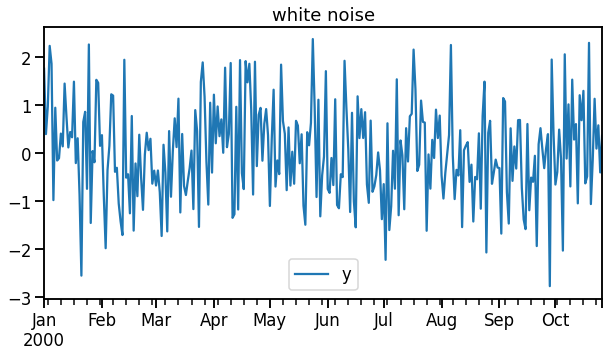

In [3]:
# Plot the time series
ax = df.plot(figsize=[10, 5])
ax.set_title("white noise")

In [4]:
# Create a copy to preserve the original dataframe for later use
df_ = df.copy()

In [5]:
# Compute the lag of the target
lag = 1
df_[f"y_lag_{lag}"] = df_["y"].shift(periods=lag)
df_.head()

,y,y_lag_1
2000-01-01,1.764052,NaN
2000-01-02,0.400157,1.764052
2000-01-03,0.978738,0.400157
2000-01-04,2.240893,0.978738
2000-01-05,1.867558,2.240893


Note: It is because of the missing data introduced by the lag that we start the sum from k+1 in the numerator.

In [6]:
# Compute the numerator and denominator in the ACF formula
y_mean = df_["y"].mean()  # Compute mean of y on entire dataset

# Drop missing values in calculating the numerator
numerator = ((df_["y"] - y_mean) * (df_[f"y_lag_{lag}"] - y_mean)).sum()

# Use all the data for computing denominator
denominator = ((df_["y"] - y_mean) ** 2).sum()

# Compute the autocorrelation at the specified lag
r = numerator / denominator
print(r)

-0.02964688962835345


In [7]:
# Compute the autocorrelation for multiple lags
r = {}
for lag in range(0, 37):
    df_ = df.copy()
    df_["y_lag"] = df_["y"].shift(lag)
    y_mean = df_["y"].mean()
    numerator = ((df_["y"] - y_mean) * (df_["y_lag"] - y_mean)).sum()
    denominator = ((df_["y"] - y_mean) ** 2).sum()
    r[lag] = numerator / denominator

acf_ = pd.Series(r)

In [8]:
acf_.head()

0    1.000000
1   -0.029647
2    0.051701
3    0.056755
4    0.004363
dtype: float64

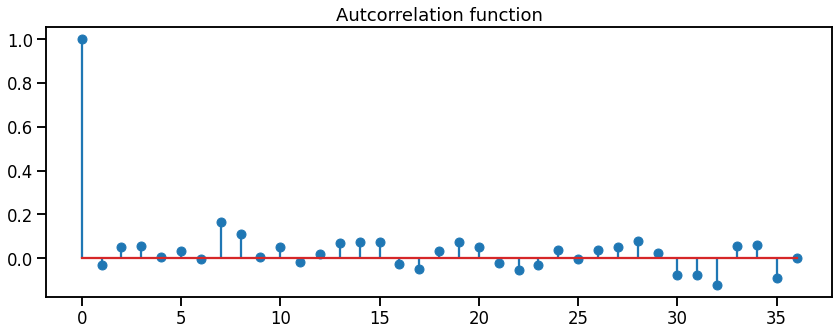

In [9]:
fig, ax = plt.subplots(figsize=[12, 5])
plt.stem(acf_)
ax.set_title("Autcorrelation function")
plt.tight_layout()

# Compute the ACF for white noise using statsmodels

In [10]:
# Create a copy to preserve the original dataframe for later use
df_ = df.copy()

In [11]:
acf_ = acf(x=df_["y"], nlags=20)
acf_

/Users/kishan_manani/.pyenv/versions/3.8.7/envs/udemy-ts/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:665: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


array([ 1.        , -0.02964689,  0.0517005 ,  0.05675462,  0.00436303,
        0.03528042, -0.00266454,  0.16528553,  0.11264096,  0.00461414,
        0.0512451 , -0.01728878,  0.01791833,  0.06893252,  0.07320845,
        0.07403495, -0.0241931 , -0.04691654,  0.03300885,  0.07272857,
        0.05298582])

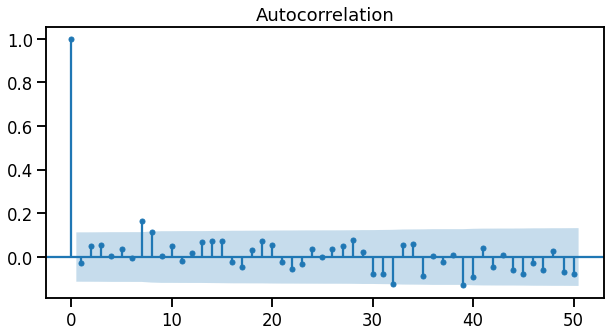

In [12]:
fig, ax = plt.subplots(figsize=[10, 5])
plot_acf(
    x=df_["y"],
    lags=50,
    ax=ax,
    alpha=0.05,
);

 - The autocorrelation is one at lag 0 as expected.
 - The autocorrelation at all other lags are not signficant. As expected from white noise.


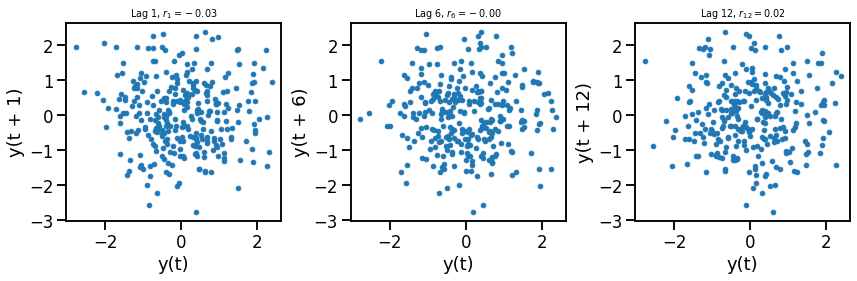

In [13]:
# Plot example lag plots
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[12, 4])

with sns.plotting_context("paper"):
    pd.plotting.lag_plot(df_["y"], lag=1, ax=ax[0])
    ax[0].set_title(f"Lag 1, $r_1={acf_[1]:.2f}$")
    ax[0].ticklabel_format(style="sci", scilimits=(0, 0))

    pd.plotting.lag_plot(df_["y"], lag=6, ax=ax[1])
    ax[1].set_title(f"Lag 6, $r_6={acf_[6]:.2f}$")
    ax[1].ticklabel_format(style="sci", scilimits=(0, 0))

    pd.plotting.lag_plot(df_["y"], lag=12, ax=ax[2])
    ax[2].set_title(f"Lag 12, $r_{{12}}={acf_[12]:.2f}$")
    ax[2].ticklabel_format(style="sci", scilimits=(0, 0))

    plt.tight_layout()

We see clearly that there is no correlation in the lag plots.

Now let's look at some timeseries with more structure and see what the ACF looks like.

# Time series with trend and seasonality

In [14]:
# Load retail sales dataset with the artificially added outliers
df = pd.read_csv(
    "../Datasets/example_retail_sales.csv",
    parse_dates=["ds"],
    index_col=["ds"],
)

Let's plot the time series

<AxesSubplot:xlabel='ds'>

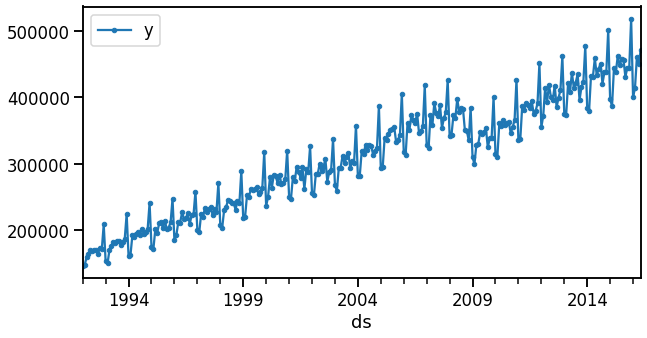

In [15]:
df.plot(y="y", marker=".", figsize=[10, 5])

Let's compute the ACF and get the output as an array

In [16]:
acf_ = acf(df["y"], nlags=36)

/Users/kishan_manani/.pyenv/versions/3.8.7/envs/udemy-ts/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:665: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


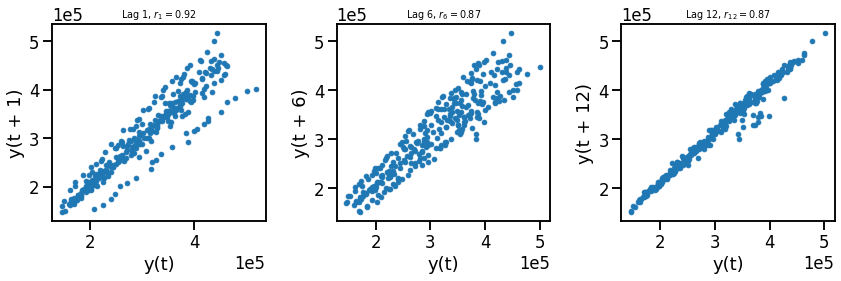

In [17]:
# Plot example lag plots
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[12, 4])

with sns.plotting_context("paper"):
    pd.plotting.lag_plot(df["y"], lag=1, ax=ax[0])
    ax[0].set_title(f"Lag 1, $r_1={acf_[1]:.2f}$")
    ax[0].ticklabel_format(style="sci", scilimits=(0, 0))

    pd.plotting.lag_plot(df["y"], lag=6, ax=ax[1])
    ax[1].set_title(f"Lag 6, $r_6={acf_[6]:.2f}$")
    ax[1].ticklabel_format(style="sci", scilimits=(0, 0))

    pd.plotting.lag_plot(df["y"], lag=12, ax=ax[2])
    ax[2].set_title(f"Lag 12, $r_{{12}}={acf_[12]:.2f}$")
    ax[2].ticklabel_format(style="sci", scilimits=(0, 0))

    plt.tight_layout()

Let's plot the ACF

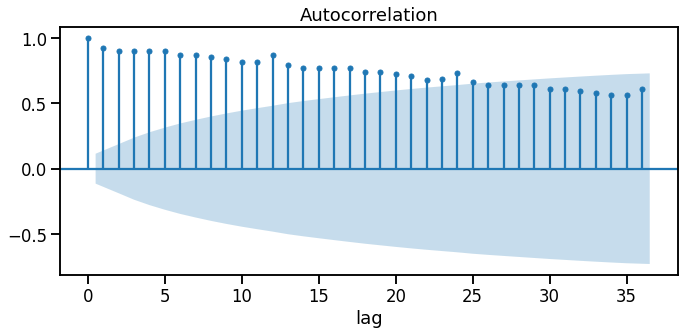

In [18]:
fig, ax = plt.subplots(figsize=[10, 5])
plot_acf(
    x=df["y"],
    lags=36,
    ax=ax,
    alpha=0.05,
)
ax.set_xlabel("lag")
plt.tight_layout()

 - The autocorrelation is one at lag 0 as expected.
 - The autocorrelation decays slowly due to the strong trend.
 - There are peaks at multiples of the seasonal lag of 12 due to the seasonality.

In summary this would suggest that we could create features using a lag of 12 (from the seasonality) and low lags like 1 or 2 (from the trend).

# ACF after de-trending the original series

The trend overwhelms the ACF. We might get more information if de-trend the data first. Let's try this.

In [19]:
# Compute the trend with LOWESS
frac = 0.1
y = df["y"]
x = np.arange(0, len(y))
res = lowess(endog=y, exog=x, frac=frac)
df["lowess"] = res[:, 1]

<AxesSubplot:xlabel='ds'>

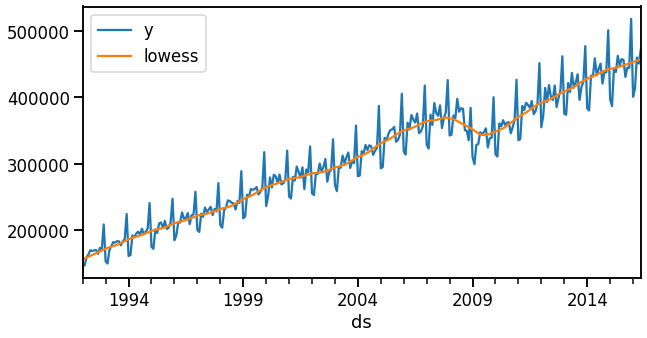

In [20]:
df.plot(figsize=(10, 5))

<AxesSubplot:xlabel='ds'>

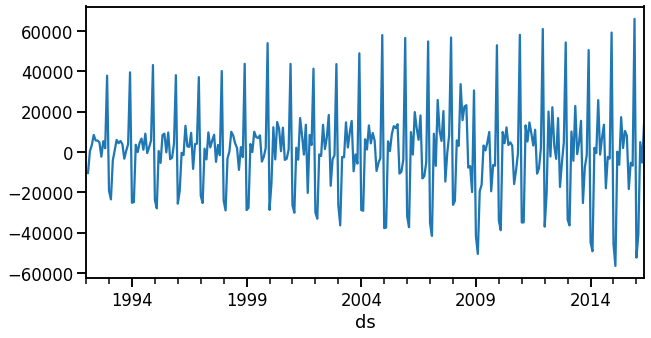

In [21]:
df["y_detrend"] = df["y"] - df["lowess"]
df["y_detrend"].plot(figsize=(10, 5))

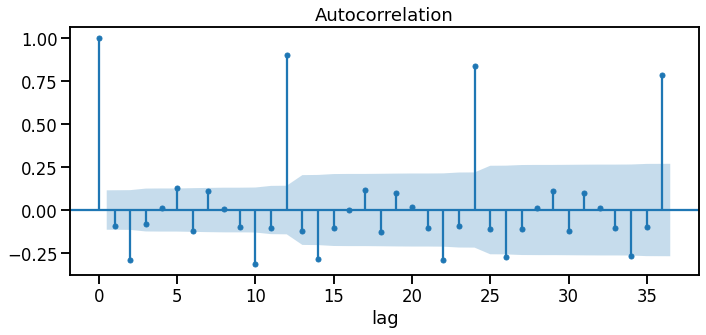

In [22]:
fig, ax = plt.subplots(figsize=[10, 5])
plot_acf(
    x=df["y_detrend"],
    lags=36,
    ax=ax,
    alpha=0.05,
)
ax.set_xlabel("lag")
plt.tight_layout()

 - There are peaks at multiples of the seasonal lag of 12 due to the seasonality. This is much clearer now that we have de-trended. 